## 3.1 环境准备

### 3.1.1 环境的创建与导入

In [1]:
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from diffusers import DDPMScheduler, UNet2DModel
from matplotlib import pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

c:\Users\dhw\.conda\envs\py312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda


### 3.1.2 数据集测试

Input shape: torch.Size([8, 1, 28, 28])
Labels: tensor([1, 7, 3, 2, 2, 6, 4, 3])


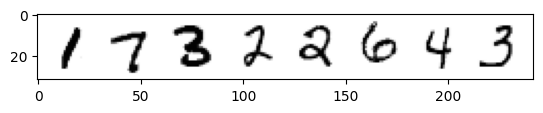

In [4]:
dataset = torchvision.datasets.MNIST(root="mnist/", train=True, download=True, transform=torchvision.transforms.ToTensor())
train_dataloader = DataLoader(dataset, batch_size=8, shuffle=True)
x, y = next(iter(train_dataloader))
print("Input shape:", x.shape)
print("Labels:", y)
plt.imshow(torchvision.utils.make_grid(x)[0], cmap='Greys')

## 3.2 扩散模型之退化过程

In [5]:
def corrupt(x, amount):
    """根据amount为输入x加入噪声，这就是退化过程"""
    noise = torch.rand_like(x)
    print("shape of nosie:", noise.shape)
    print("shape of amount:", amount.shape)
    amount = amount.view(-1, 1, 1, 1)
    print("shape of amount:", amount.shape)
    return x*(1-amount) + noise*amount

shape of nosie: torch.Size([8, 1, 28, 28])
shape of amount: torch.Size([8])
shape of amount: torch.Size([8, 1, 1, 1])


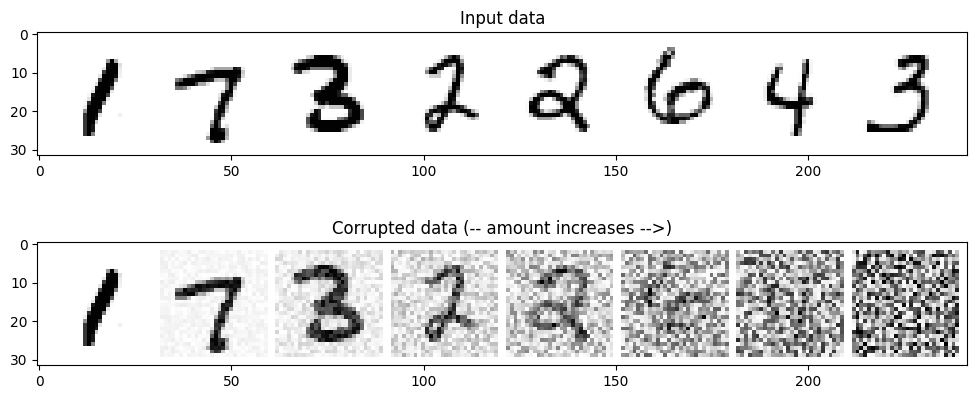

In [6]:
# 绘制输入数据
fig, axs = plt.subplots(2, 1, figsize=(12, 5))
axs[0].set_title('Input data')
axs[0].imshow(torchvision.utils.make_grid(x)[0], cmap='Greys')

# 加入噪声
amount = torch.linspace(0, 1, x.shape[0])   # 从 0 到 1，退化更强烈了
noised_x = corrupt(x, amount)

# 绘制加噪版本的图像
axs[1].set_title('Corrupted data (-- amount increases -->)')
axs[1].imshow(torchvision.utils.make_grid(noised_x)[0], cmap='Greys')

## 扩散模型之训练

### UNet网络

In [11]:
class BasicUNet(nn.Module):
    """一个十分简单的UNet网络部署"""
    def __init__(self, in_channels=1, out_channels=1, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.down_layers = torch.nn.ModuleList([
            nn.Conv2d(in_channels, 32, kernel_size=5, padding=2),
            nn.Conv2d(32, 64, kernel_size=5, padding=2),
            nn.Conv2d(64, 64, kernel_size=5, padding=2),
        ])
        self.up_layers = torch.nn.ModuleList([
            nn.Conv2d(64, 64, kernel_size=5, padding=2),
            nn.Conv2d(64, 32, kernel_size=5, padding=2),
            nn.Conv2d(32, out_channels, kernel_size=5, padding=2),
        ])
        self.act = nn.ReLU()   # 激活函数
        self.downscale = nn.MaxPool2d(2)
        self.upscale = nn.Upsample(scale_factor=2)
    
    def forward(self, x):
        h = []
        for i, l in enumerate(self.down_layers):
            x = self.act(l(x))  # 通过运算层与激活函数
            if i<2: # 选择除了第三层（最后一层）以外的层
                h.append(x) # 排列供残差连接使用的数据
                x = self.downscale(x)   # 进行下采样以适配下一层的输入
        for i, l in enumerate(self.up_layers):
            if i>0: # 选择除了第1个上采样层以外的层
                x = self.upscale(x)
                x += h.pop()
            x = self.act(l(x))  # 通过运算层与激活函数
        return x

In [12]:
net = BasicUNet()
x = torch.rand(8, 1, 28, 28)
net(x).shape

torch.Size([8, 1, 28, 28])

In [14]:
sum([p.numel() for p in net.parameters()] )

309057